In [1]:
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, v2
from perlin_noise import PerlinNoise
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import os
from glob import glob
from PIL import Image
import random
import torch.nn.functional as F
from torchvision.ops import sigmoid_focal_loss
import torch.nn.functional as F
from torch.autograd import Variable
import math
from math import exp
import imgaug.augmenters as iaa
from torchmetrics.classification import AveragePrecision, AUROC

# impostazione del seed

In [2]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)

set_seed(42)

# impostazione del device: GPU with cuda

In [3]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Generatore del rumore: Perlin noise

In [4]:
def lerp_np(x,y,w):
    fin_out = (y-x)*w + x
    return fin_out

def generate_fractal_noise_2d(shape, res, octaves=1, persistence=0.8):
    noise = np.zeros(shape)
    frequency = 1
    amplitude = 1
    #octaves = random.randint(2,6)
    #octave=random.randint(2,6)
    for _ in range(octaves):
        noise += amplitude * generate_perlin_noise_2d(shape, (frequency*res[0], frequency*res[1]))
        frequency *= 2
        amplitude *= persistence
    return noise


def generate_perlin_noise_2d(shape, res):
    def f(t):
        return 6 * t ** 5 - 15 * t ** 4 + 10 * t ** 3

    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    grid = np.mgrid[0:res[0]:delta[0], 0:res[1]:delta[1]].transpose(1, 2, 0) % 1
    # Gradients
    angles = 2 * np.pi * np.random.rand(res[0] + 1, res[1] + 1)
    gradients = np.dstack((np.cos(angles), np.sin(angles)))
    g00 = gradients[0:-1, 0:-1].repeat(d[0], 0).repeat(d[1], 1)
    g10 = gradients[1:, 0:-1].repeat(d[0], 0).repeat(d[1], 1)
    g01 = gradients[0:-1, 1:].repeat(d[0], 0).repeat(d[1], 1)
    g11 = gradients[1:, 1:].repeat(d[0], 0).repeat(d[1], 1)
    # Ramps
    n00 = np.sum(grid * g00, 2)
    n10 = np.sum(np.dstack((grid[:, :, 0] - 1, grid[:, :, 1])) * g10, 2)
    n01 = np.sum(np.dstack((grid[:, :, 0], grid[:, :, 1] - 1)) * g01, 2)
    n11 = np.sum(np.dstack((grid[:, :, 0] - 1, grid[:, :, 1] - 1)) * g11, 2)
    # Interpolation
    t = f(grid)
    n0 = n00 * (1 - t[:, :, 0]) + t[:, :, 0] * n10
    n1 = n01 * (1 - t[:, :, 0]) + t[:, :, 0] * n11
    return np.sqrt(2) * ((1 - t[:, :, 1]) * n0 + t[:, :, 1] * n1)


def rand_perlin_2d_np(shape, res, fade=lambda t: 6 * t ** 5 - 15 * t ** 4 + 10 * t ** 3):
    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    grid = np.mgrid[0:res[0]:delta[0], 0:res[1]:delta[1]].transpose(1, 2, 0) % 1

    angles = 2 * math.pi * np.random.rand(res[0] + 1, res[1] + 1)
    gradients = np.stack((np.cos(angles), np.sin(angles)), axis=-1)
    tt = np.repeat(np.repeat(gradients,d[0],axis=0),d[1],axis=1)

    tile_grads = lambda slice1, slice2: np.repeat(np.repeat(gradients[slice1[0]:slice1[1], slice2[0]:slice2[1]],d[0],axis=0),d[1],axis=1)
    dot = lambda grad, shift: (
                np.stack((grid[:shape[0], :shape[1], 0] + shift[0], grid[:shape[0], :shape[1], 1] + shift[1]),
                            axis=-1) * grad[:shape[0], :shape[1]]).sum(axis=-1)

    n00 = dot(tile_grads([0, -1], [0, -1]), [0, 0])
    n10 = dot(tile_grads([1, None], [0, -1]), [-1, 0])
    n01 = dot(tile_grads([0, -1], [1, None]), [0, -1])
    n11 = dot(tile_grads([1, None], [1, None]), [-1, -1])
    t = fade(grid[:shape[0], :shape[1]])
    return math.sqrt(2) * lerp_np(lerp_np(n00, n10, t[..., 0]), lerp_np(n01, n11, t[..., 0]), t[..., 1])


def rand_perlin_2d(shape, res, fade=lambda t: 6 * t ** 5 - 15 * t ** 4 + 10 * t ** 3):
    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])

    grid = torch.stack(torch.meshgrid(torch.arange(0, res[0], delta[0]), torch.arange(0, res[1], delta[1])), dim=-1) % 1
    angles = 2 * math.pi * torch.rand(res[0] + 1, res[1] + 1)
    gradients = torch.stack((torch.cos(angles), torch.sin(angles)), dim=-1)

    tile_grads = lambda slice1, slice2: gradients[slice1[0]:slice1[1], slice2[0]:slice2[1]].repeat_interleave(d[0],
                                                                                                              0).repeat_interleave(
        d[1], 1)
    dot = lambda grad, shift: (
                torch.stack((grid[:shape[0], :shape[1], 0] + shift[0], grid[:shape[0], :shape[1], 1] + shift[1]),
                            dim=-1) * grad[:shape[0], :shape[1]]).sum(dim=-1)

    n00 = dot(tile_grads([0, -1], [0, -1]), [0, 0])

    n10 = dot(tile_grads([1, None], [0, -1]), [-1, 0])
    n01 = dot(tile_grads([0, -1], [1, None]), [0, -1])
    n11 = dot(tile_grads([1, None], [1, None]), [-1, -1])
    t = fade(grid[:shape[0], :shape[1]])
    return math.sqrt(2) * torch.lerp(torch.lerp(n00, n10, t[..., 0]), torch.lerp(n01, n11, t[..., 0]), t[..., 1])


def rand_perlin_2d_octaves(shape, res, octaves=5, persistence=0.5):
    noise = torch.zeros(shape)
    frequency = 1
    amplitude = 1
    for _ in range(octaves):
        noise += amplitude * rand_perlin_2d(shape, (frequency * res[0], frequency * res[1]))
        frequency *= 2
        amplitude *= persistence
    return noise

## Customized Dataset: MVTecDRAEMTrainDataset e MVTecDRAEMTestDataset

In [5]:
class MVTecDRAEMTrainDataset(Dataset):

    def __init__(self, root_dir, anomaly_source_path, resize_shape=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.resize_shape=resize_shape

        self.image_paths = sorted(glob(root_dir+"/*.png"))

        self.anomaly_source_paths = sorted(glob(anomaly_source_path+"/*/*.jpg"))

        self.augmenters = [iaa.GammaContrast((0.5,2.0),per_channel=True),
                      iaa.MultiplyAndAddToBrightness(mul=(0.8,1.2),add=(-30,30)),
                      iaa.pillike.EnhanceSharpness(),
                      iaa.AddToHueAndSaturation((-50,50),per_channel=True),
                      iaa.Solarize(0.5, threshold=(32,128)),
                      iaa.Posterize(),
                      iaa.Invert(),
                      iaa.pillike.Autocontrast(),
                      iaa.pillike.Equalize(),
                      iaa.Affine(rotate=(-45, 45))
                      ]

        self.rot = iaa.Sequential([iaa.Affine(rotate=(-90, 90))])


    def __len__(self):
        return len(self.image_paths)


    def randAugmenter(self):
        aug_ind = np.random.choice(np.arange(len(self.augmenters)), 3, replace=False)
        aug = iaa.Sequential([self.augmenters[aug_ind[0]],
                              self.augmenters[aug_ind[1]],
                              self.augmenters[aug_ind[2]]]
                             )
        return aug

    def augment_image(self, image, anomaly_source_path):
        aug = self.randAugmenter()
        perlin_scale = 6
        min_perlin_scale = 0
        anomaly_source_img = cv.imread(anomaly_source_path)
        anomaly_source_img = cv.resize(anomaly_source_img, dsize=(self.resize_shape[1], self.resize_shape[0]))

        anomaly_img_augmented = aug(image=anomaly_source_img)
        perlin_scalex = 2 ** (torch.randint(min_perlin_scale, perlin_scale, (1,)).numpy()[0])
        perlin_scaley = 2 ** (torch.randint(min_perlin_scale, perlin_scale, (1,)).numpy()[0])

        perlin_noise = rand_perlin_2d_np((self.resize_shape[0], self.resize_shape[1]), (perlin_scalex, perlin_scaley))
        perlin_noise = self.rot(image=perlin_noise)
        threshold = 0.5
        perlin_thr = np.where(perlin_noise > threshold, np.ones_like(perlin_noise), np.zeros_like(perlin_noise))
        perlin_thr = np.expand_dims(perlin_thr, axis=2)

        img_thr = anomaly_img_augmented.astype(np.float32) * perlin_thr / 255.0

        beta = torch.rand(1).numpy()[0] * 0.8

        augmented_image = image * (1 - perlin_thr) + (1 - beta) * img_thr + beta * image * (
            perlin_thr)

        no_anomaly = torch.rand(1).numpy()[0]
        if no_anomaly > 0.95:
            image = image.astype(np.float32)
            return image, np.zeros_like(perlin_thr, dtype=np.float32), np.array([0.0],dtype=np.float32)
        else:
            augmented_image = augmented_image.astype(np.float32)
            msk = (perlin_thr).astype(np.float32)
            augmented_image = msk * augmented_image + (1-msk)*image
            has_anomaly = 1.0
            if np.sum(msk) == 0:
                has_anomaly=0.0
            return augmented_image, msk, np.array([has_anomaly],dtype=np.float32)

    def transform_image(self, image_path, anomaly_source_path):
        image = cv.imread(image_path)
        image = cv.resize(image, dsize=(self.resize_shape[1], self.resize_shape[0]))

        do_aug_orig = torch.rand(1).numpy()[0] > 0.7
        if do_aug_orig:
            image = self.rot(image=image)

        image = np.array(image).reshape((image.shape[0], image.shape[1], image.shape[2])).astype(np.float32) / 255.0
        augmented_image, anomaly_mask, has_anomaly = self.augment_image(image, anomaly_source_path)
        augmented_image = np.transpose(augmented_image, (2, 0, 1))
        image = np.transpose(image, (2, 0, 1))
        anomaly_mask = np.transpose(anomaly_mask, (2, 0, 1))
        return image, augmented_image, anomaly_mask, has_anomaly

    def __getitem__(self, idx):
        idx = torch.randint(0, len(self.image_paths), (1,)).item()
        anomaly_source_idx = torch.randint(0, len(self.anomaly_source_paths), (1,)).item()
        image, augmented_image, anomaly_mask, has_anomaly = self.transform_image(self.image_paths[idx],
                                                                           self.anomaly_source_paths[anomaly_source_idx])
        sample = {'image': image, "anomaly_mask": anomaly_mask,
                  'augmented_image': augmented_image, 'has_anomaly': has_anomaly, 'idx': idx}

        return sample

In [6]:
class MVTecDRAEMTestDataset(Dataset):

    def __init__(self, root_dir, resize_shape=None):
        self.root_dir = root_dir
        self.images = sorted(glob(root_dir+"/*/*.png"))
        self.resize_shape=resize_shape

    def __len__(self):
        return len(self.images)

    def transform_image(self, image_path, mask_path):
        image = cv.imread(image_path, cv.IMREAD_COLOR)
        if mask_path is not None:
            mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
        else:
            mask = np.zeros((image.shape[0],image.shape[1]))
        if self.resize_shape != None:
            image = cv.resize(image, dsize=(self.resize_shape[1], self.resize_shape[0]))
            mask = cv.resize(mask, dsize=(self.resize_shape[1], self.resize_shape[0]))

        image = image / 255.0
        mask = mask / 255.0

        image = np.array(image).reshape((image.shape[0], image.shape[1], 3)).astype(np.float32)
        mask = np.array(mask).reshape((mask.shape[0], mask.shape[1], 1)).astype(np.float32)

        image = np.transpose(image, (2, 0, 1))
        mask = np.transpose(mask, (2, 0, 1))
        return image, mask

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.images[idx]
        dir_path, file_name = os.path.split(img_path)
        base_dir = os.path.basename(dir_path)
        if base_dir == 'good':
            image, mask = self.transform_image(img_path, None)
            has_anomaly = np.array([0], dtype=np.float32)
        else:
            mask_path = os.path.join(dir_path, '../../ground_truth/')
            #mask_path = os.path.join(mask_path, base_dir) #thb
            mask_path = os.path.join(mask_path, base_dir) #thb
            mask_file_name = file_name.split(".")[0]+"_mask.png"
            mask_path = os.path.join(mask_path, mask_file_name)
            image, mask = self.transform_image(img_path, mask_path)
            has_anomaly = np.array([1], dtype=np.float32)

        sample = {'image': image, 'has_anomaly': has_anomaly, 'mask': mask, 'idx': idx}

        return sample

# Implementazione del modello
## 1) Autoencoder

In [7]:
# Autoencoder
class AutoEncoder(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=dropout_prob),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.Dropout(p=dropout_prob),
            

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=dropout_prob),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.Dropout(p=dropout_prob),

            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=dropout_prob),
        )

        # Decoder
        self.decoder = nn.Sequential(
            
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_prob),

            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            #nn.Dropout(p=dropout_prob),

            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            #nn.Dropout(p=dropout_prob),

            nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2),
        )

    def forward(self, dato):
        encoder = self.encoder(dato)
        decoder = self.decoder(encoder)
        return decoder

## 2) Unet

In [8]:
class DoubleOnv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.05):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_prob)
        )
    
    def forward(self, x):
        return self.conv_block(x)

In [9]:
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleOnv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        conv = self.conv(x)
        pool = self.pool(conv)
        return conv, pool

In [10]:
class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleOnv(in_channels, out_channels)

    def forward(self, x1, x2):
        conv_trans = self.up(x1)
        conv = torch.cat([conv_trans, x2], 1)
        return self.conv(conv)

In [11]:
# Unet
class Unet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.e1 = DownSample(in_channels, 64)
        self.e2 = DownSample(64, 128)
        self.e3 = DownSample(128, 256)
        self.e4 = DownSample(256, 512)

        self.bottle_neck = DoubleOnv(512, 1024)

        self.d1 = Upsample(1024, 512)
        self.d2 = Upsample(512, 256)
        self.d3 = Upsample(256, 128)
        self.d4 = Upsample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, padding=1)

    def forward(self, x):
        e1, s1 = self.e1(x)
        e2, s2 = self.e2(s1)
        e3, s3 = self.e3(s2)
        e4, s4 = self.e4(s3)

        b = self.bottle_neck(s4)

        d1 = self.d1(b, e4)
        d2 = self.d2(d1, e3)
        d3 = self.d3(d2, e2)
        d4 = self.d4(d3, e1)

        out = self.out(d4)

        return out

## Implementazione dei Funzioni di Loss: SSIM e Focal Loss

In [12]:
class FocalLoss(nn.Module):
    """
    copy from: https://github.com/Hsuxu/Loss_ToolBox-PyTorch/blob/master/FocalLoss/FocalLoss.py
    This is a implementation of Focal Loss with smooth label cross entropy supported which is proposed in
    'Focal Loss for Dense Object Detection. (https://arxiv.org/abs/1708.02002)'
        Focal_Loss= -1*alpha*(1-pt)*log(pt)
    :param alpha: (tensor) 3D or 4D the scalar factor for this criterion
    :param gamma: (float,double) gamma > 0 reduces the relative loss for well-classified examples (p>0.5) putting more
                    focus on hard misclassified example
    :param smooth: (float,double) smooth value when cross entropy
    :param balance_index: (int) balance class index, should be specific when alpha is float
    :param size_average: (bool, optional) By default, the losses are averaged over each loss element in the batch.
    """

    def __init__(self, apply_nonlin=None, alpha=None, gamma=2, balance_index=0, smooth=1e-5, size_average=True):
        super(FocalLoss, self).__init__()
        self.apply_nonlin = apply_nonlin
        self.alpha = alpha
        self.gamma = gamma
        self.balance_index = balance_index
        self.smooth = smooth
        self.size_average = size_average

        if self.smooth is not None:
            if self.smooth < 0 or self.smooth > 1.0:
                raise ValueError('smooth value should be in [0,1]')

    def forward(self, logit, target):
        if self.apply_nonlin is not None:
            logit = self.apply_nonlin(logit)
        num_class = logit.shape[1]

        if logit.dim() > 2:
            # N,C,d1,d2 -> N,C,m (m=d1*d2*...)
            logit = logit.view(logit.size(0), logit.size(1), -1)
            logit = logit.permute(0, 2, 1).contiguous()
            logit = logit.view(-1, logit.size(-1))
        target = torch.squeeze(target, 1)
        target = target.view(-1, 1)
        alpha = self.alpha

        if alpha is None:
            alpha = torch.ones(num_class, 1)
        elif isinstance(alpha, (list, np.ndarray)):
            assert len(alpha) == num_class
            alpha = torch.FloatTensor(alpha).view(num_class, 1)
            alpha = alpha / alpha.sum()
        elif isinstance(alpha, float):
            alpha = torch.ones(num_class, 1)
            alpha = alpha * (1 - self.alpha)
            alpha[self.balance_index] = self.alpha

        else:
            raise TypeError('Not support alpha type')

        if alpha.device != logit.device:
            alpha = alpha.to(logit.device)

        idx = target.cpu().long()

        one_hot_key = torch.FloatTensor(target.size(0), num_class).zero_()
        one_hot_key = one_hot_key.scatter_(1, idx, 1)
        if one_hot_key.device != logit.device:
            one_hot_key = one_hot_key.to(logit.device)

        if self.smooth:
            one_hot_key = torch.clamp(
                one_hot_key, self.smooth / (num_class - 1), 1.0 - self.smooth)
        pt = (one_hot_key * logit).sum(1) + self.smooth
        logpt = pt.log()

        gamma = self.gamma

        alpha = alpha[idx]
        alpha = torch.squeeze(alpha)
        loss = -1 * alpha * torch.pow((1 - pt), gamma) * logpt

        if self.size_average:
            loss = loss.mean()
        return loss

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel=1):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

def ssim(img1, img2, window_size=11, window=None, size_average=True, full=False, val_range=None):
    if val_range is None:
        if torch.max(img1) > 128:
            max_val = 255
        else:
            max_val = 1

        if torch.min(img1) < -0.5:
            min_val = -1
        else:
            min_val = 0
        l = max_val - min_val
    else:
        l = val_range

    padd = window_size//2
    (_, channel, height, width) = img1.size()
    if window is None:
        real_size = min(window_size, height, width)
        window = create_window(real_size, channel=channel).to(img1.device)

    mu1 = F.conv2d(img1, window, padding=padd, groups=channel)
    mu2 = F.conv2d(img2, window, padding=padd, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=padd, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=padd, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=padd, groups=channel) - mu1_mu2

    c1 = (0.01 * l) ** 2
    c2 = (0.03 * l) ** 2

    v1 = 2.0 * sigma12 + c2
    v2 = sigma1_sq + sigma2_sq + c2
    cs = torch.mean(v1 / v2)  # contrast sensitivity

    ssim_map = ((2 * mu1_mu2 + c1) * v1) / ((mu1_sq + mu2_sq + c1) * v2)

    if size_average:
        ret = ssim_map.mean()
    else:
        ret = ssim_map.mean(1).mean(1).mean(1)

    if full:
        return ret, cs
    return ret, ssim_map


class SSIM(torch.nn.Module):
    def __init__(self, window_size=11, size_average=True, val_range=None):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.val_range = val_range

        # Assume 1 channel for SSIM
        self.channel = 1
        self.window = create_window(window_size).cuda()

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.dtype == img1.dtype:
            window = self.window
        else:
            window = create_window(self.window_size, channel).to(img1.device).type(img1.dtype)
            self.window = window
            self.channel = channel

        s_score, ssim_map = ssim(img1, img2, window=window, window_size=self.window_size, size_average=self.size_average)
        return 1.0 - s_score

## Modello Completo: Draem

In [13]:
class Draem(nn.Module):
    def __init__(self):
        super().__init__()
        self.autoencoder = AutoEncoder()
        self.unet = Unet(in_channels=6, num_classes=2) 

    def forward(self, x_augmented):
        """
        x_augmented : image corrompue (augmented_image) avec anomalies synthétiques injectées
        Retourne :
         - reconstruction : l'image restaurée par l'autoencodeur
         - anomaly_mask_pred : la carte d'anomalie prédite par le segmentateur
        """
        # Reconstruction de l'image corrompue
        reconstruction = self.autoencoder(x_augmented)
        #print(f"{reconstruction.shape} r")
        #print(f"aug: {x_augmented.shape}, rec: {reconstruction.shape}")
        joined_input = torch.cat((reconstruction, x_augmented), dim=1)
        #print(f"{joined_input.shape} cat")
        
        anomaly_logits = self.unet(joined_input)
        anomaly_mask_pred = torch.softmax(anomaly_logits, dim=1)
        
        return reconstruction, anomaly_mask_pred

# Dataloaders

In [14]:
img_dim = 256
images_def = "./toothbrush/test/" 
#images_def = "./cable/test/"
dataset = MVTecDRAEMTrainDataset("./toothbrush/train/good", "./dtd/images", resize_shape=[img_dim, img_dim])
dataset_test = MVTecDRAEMTestDataset(images_def, resize_shape=[img_dim, img_dim])

print(len(dataset))
print(len(dataset_test))

dataloader_train = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)
dataloader_test = DataLoader(dataset_test, batch_size=4, shuffle=False, num_workers=4)
dataloader_val = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=2)

print(len(dataloader_train))
print(len(dataloader_test))
print(len(dataloader_val))
#print(len(dataloader_good_test))

60
42
15
11
42


## Controlli

In [15]:
for batch in dataloader_test:
    print(batch["image"].shape, batch["mask"].shape)
    #print("Hi")

torch.Size([4, 3, 256, 256]) torch.Size([4, 1, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 1, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 1, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 1, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 1, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 1, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 1, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 1, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 1, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 1, 256, 256])
torch.Size([2, 3, 256, 256]) torch.Size([2, 1, 256, 256])


tensor(0.9098)


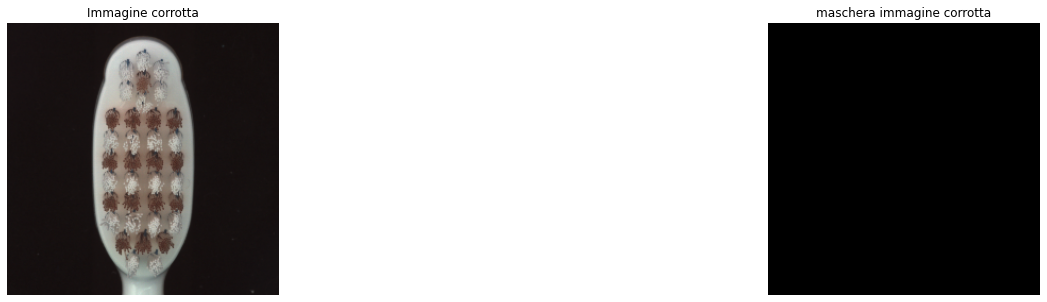

tensor(0.8784)


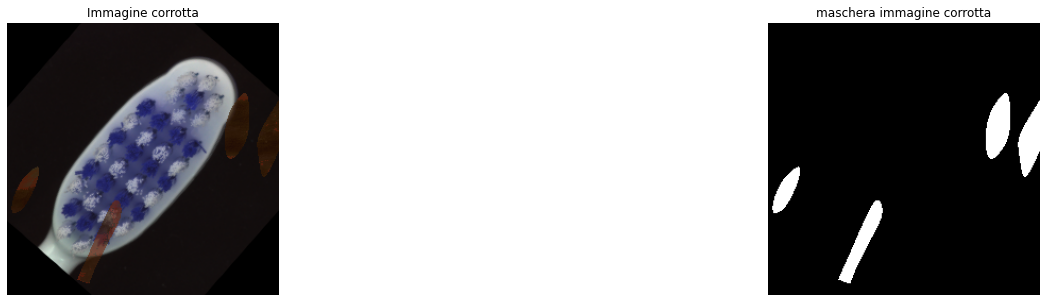

tensor(0.8748)


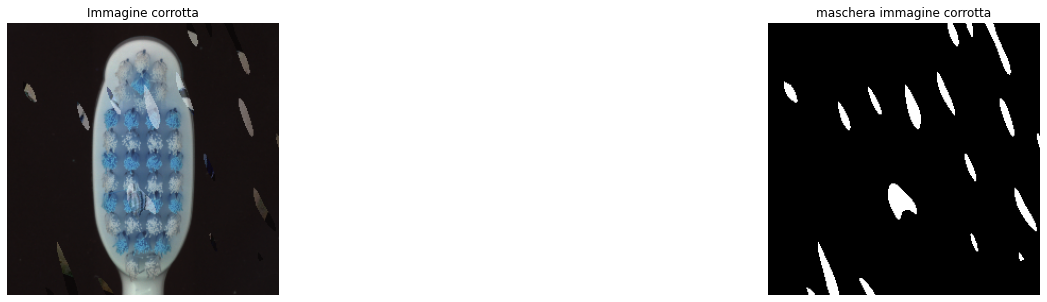

tensor(0.8863)


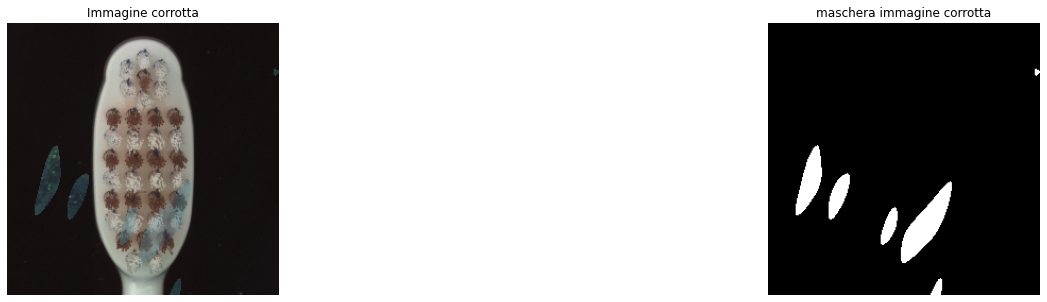

tensor(0.8825)


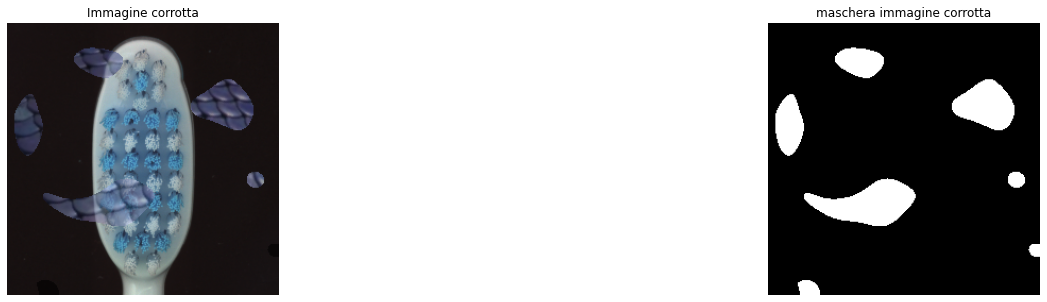

tensor(0.9176)


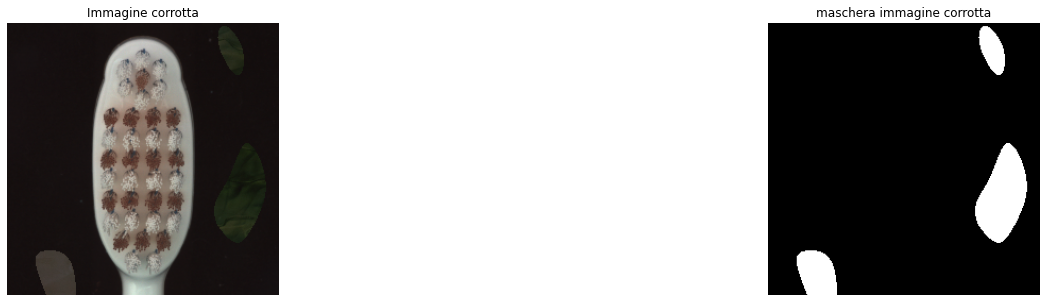

tensor(0.9893)


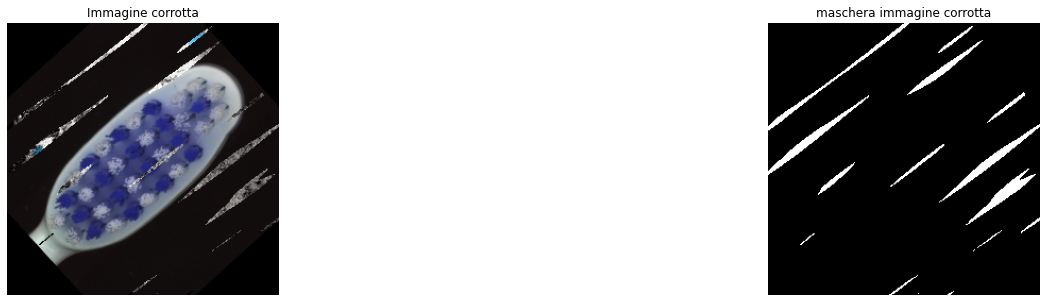

tensor(0.8157)


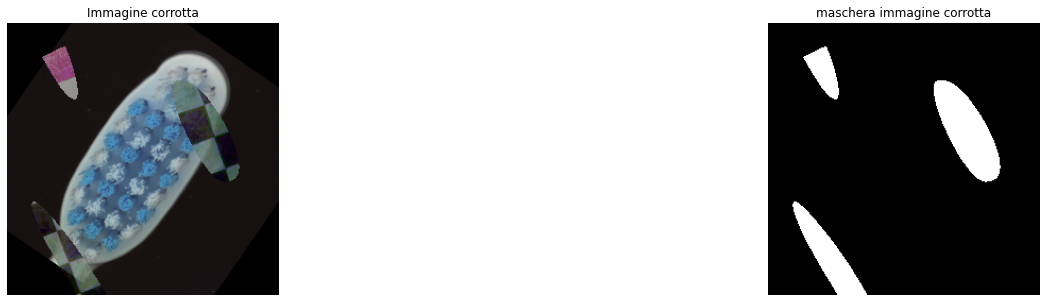

tensor(0.9098)


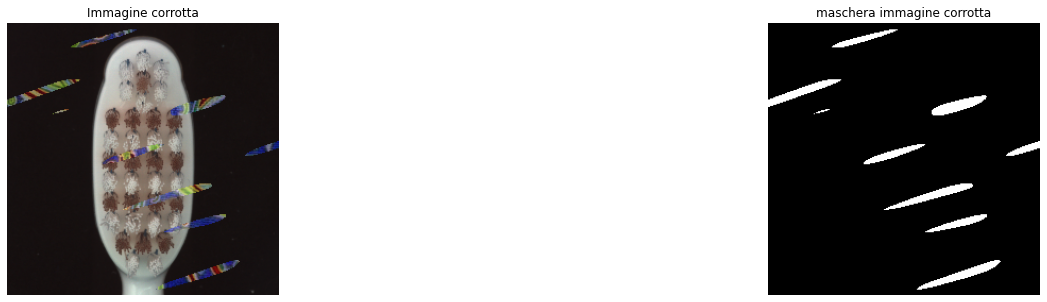

tensor(0.9931)


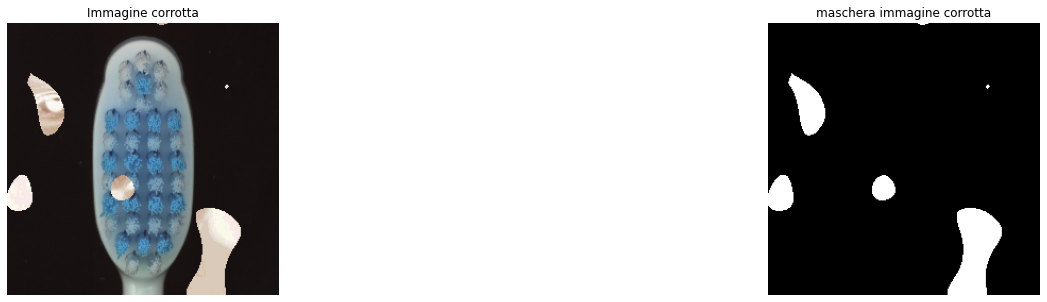

tensor(0.8941)


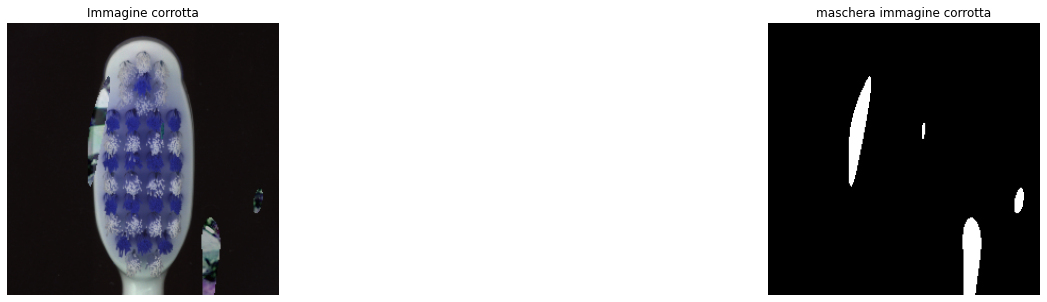

tensor(0.8549)


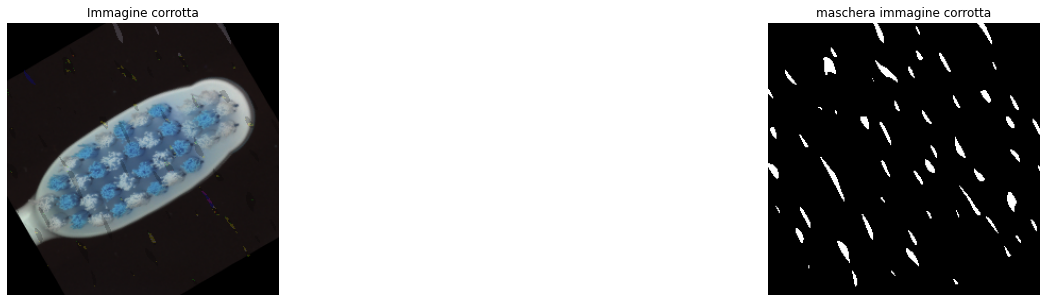

tensor(0.8941)


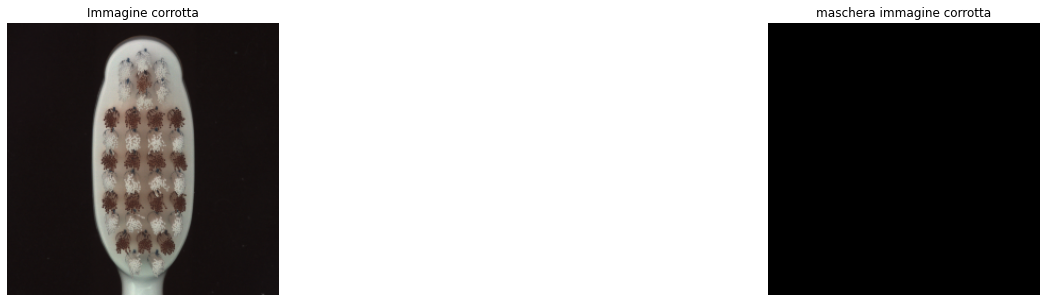

tensor(0.9302)


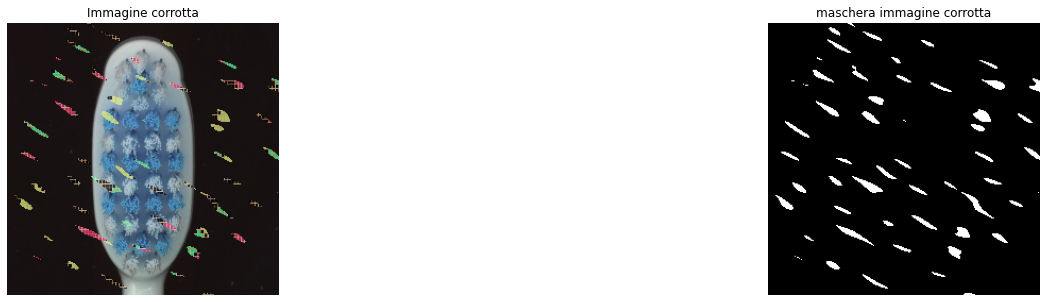

tensor(0.9098)


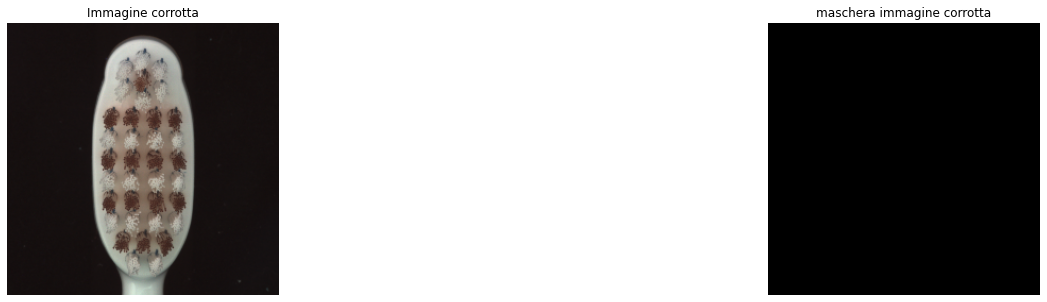

In [16]:
for i, jj in enumerate(dataloader_train):
    print(jj["augmented_image"][1].max())
    fig, axs = plt.subplots(1,2, figsize=(25,5))
    axs[0].imshow(jj["augmented_image"][1].cpu().permute(1,2,0).numpy(), cmap="gray")
    axs[0].set_title("Immagine corrotta")
    axs[0].axis("off")

    axs[1].imshow(jj["anomaly_mask"][1].cpu().permute(1,2,0).numpy(), cmap="gray")
    axs[1].set_title("maschera immagine corrotta")
    axs[1].axis("off")
    plt.show()

## Funzioni di train e di test

In [17]:
def train_step(model, dataloader_train, optimizer, reconstruction_loss, loss_l2, seg_loss_fn, epoch):
    model.train()
    size = len(dataloader_train)
    train_running_loss, train_running_loss_l2, train_running_loss_ssim, train_running_loss_focal = 0, 0, 0, 0
    for sample_batched in dataloader_train:
        inputs = sample_batched["image"].to(device)  # Images corrompues [B, 3, H, W]
        aug_img = sample_batched["augmented_image"].to(device)
        gt_seg = sample_batched["anomaly_mask"].to(device)
        
        rec, anomaly_logits = model(aug_img)
        #print(rec.shape)
        #print(anomaly_logits.shape)
        #print(gt_seg.shape)
        # Calcul de la perte de reconstruction
        #loss_rec = reconstruction_loss(inputs, rec, lambda_ssim=lambda_ssim)
        ssim_loss = reconstruction_loss(rec, inputs)
        l2_loss = loss_l2(rec, inputs)
        
        loss_seg = seg_loss_fn(anomaly_logits, gt_seg)
    
        loss = ssim_loss + l2_loss + loss_seg

        train_running_loss += loss.item()
        train_running_loss_l2 += l2_loss.item()
        train_running_loss_ssim += ssim_loss.item()
        train_running_loss_focal += loss_seg.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss, train_loss_l2 = train_running_loss / size, train_running_loss_l2 / size
    train_loss_ssim, train_loss_focal = train_running_loss_ssim / size, train_running_loss_focal / size

    print(f"Total Avg Train Loss: {train_loss:.4f} | Avg L2 Loss: {train_loss_l2:.4f}| Avg SSIM Loss: {train_loss_ssim:.4f}| Avg Reconstructive Loss: {train_loss_l2+train_loss_ssim:.4f} | Avg Seg Loss: {train_loss_focal:.4f}")
    return train_loss

In [18]:
def test_step(model, dataloader_test, reconstruction_loss, loss_l2, seg_loss_fn, epoch):
    model.eval()
    test_running_loss, test_running_loss_l2, test_running_loss_ssim, test_running_loss_focal = 0, 0, 0, 0
    average_precision = AveragePrecision(task="binary").to(device)
    auroc = AUROC(task="binary").to(device)
    size = len(dataloader_test) 
    with torch.no_grad():
        for sample_batched in dataloader_test:
            inputs = sample_batched["image"].to(device)
            gt_seg = sample_batched["mask"].to(device)
            
            rec, anomaly_logits = model(inputs)
    
            ssim_loss = reconstruction_loss(rec, inputs)
            l2_loss = loss_l2(rec, inputs)
        
            
            loss_seg = seg_loss_fn(anomaly_logits, gt_seg)
        
            loss = ssim_loss + l2_loss + loss_seg

            test_running_loss += loss.item()
            test_running_loss_l2 += l2_loss.item()
            test_running_loss_ssim += ssim_loss.item()
            test_running_loss_focal += loss_seg.item()
            probs = anomaly_logits[:, 1, :, :]
            targets = gt_seg.squeeze(1).int() 
            average_precision.update(probs.flatten(), targets.flatten())
            auroc.update(probs.flatten(), targets.flatten())

            
    avg_loss = test_running_loss / size
    avg_loss_l2 = test_running_loss_l2 / size
    avg_loss_ssim = test_running_loss_ssim / size
    avg_loss_focal = test_running_loss_focal / size
    ap = average_precision.compute()
    roc_auc = auroc.compute()
    
    print(f"Total Avg Test Loss: {avg_loss:.4f} | Avg L2 Loss: {(avg_loss_l2):.4f} |Avg SSIM Loss: {(avg_loss_ssim):.4f}| Avg Rec Loss: {(avg_loss_l2+avg_loss_ssim):.4f} | Avg Seg Loss: {avg_loss_focal:.4f} ")
    print(f"Average Precision: {ap:.4f} | AUROC: {roc_auc:.4f}")
    return avg_loss, ap

## Early Stopping e initiazializzazione dei pesi

In [19]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

In [20]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

## addestramento

In [21]:
EPOCH = 700
LR = 1e-4
#--------
train_losses = []
val_losses = []
early_stopping = EarlyStopping(tolerance=5, min_delta=10)
model = Draem().to(device)
model.apply(weights_init)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
loss_l2 = torch.nn.MSELoss()    
rec_loss = SSIM()
loss_focal = FocalLoss()  

actual_lr = LR
best_test_loss = -float('inf')
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=20, factor=0.3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[300, 550], gamma=0.1, last_epoch=-1)

for epoch in range(EPOCH):  # nombre d'époques  
    #if epoch%50==0:
    print(f"------ Epoch {epoch+1} ------")
    train_loss = train_step(model, dataloader_train, optimizer, rec_loss, loss_l2, loss_focal, epoch)
    val_loss, ap_loss = test_step(model, dataloader_test, rec_loss, loss_l2, loss_focal, epoch)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if actual_lr != scheduler.get_last_lr()[0]:
        print(f"Epoch {epoch}, LR: {scheduler.get_last_lr()[0]:.12f}")
        actual_lr = scheduler.get_last_lr()[0]
        
    #if epoch%50==0:
    print("------ Done ------ !")

    if ap_loss > best_test_loss:
        best_test_loss = ap_loss
        torch.save(model.state_dict(), "draem_model.pckl")
        print(f"Epoch {epoch}: Nouovo miglior modello salvato con test_loss = {ap_loss:.6f}")
    
    #scheduler.step(ap_loss)
    scheduler.step()
    
   # early stopping
    early_stopping(train_loss, val_loss)
    if early_stopping.early_stop:
      print(f"We are at epoch:{epoch}",)
      break

------ Epoch 1 ------
Total Avg Train Loss: 0.9495 | Avg L2 Loss: 0.1085| Avg SSIM Loss: 0.7086| Avg Reconstructive Loss: 0.8171 | Avg Seg Loss: 0.1324
Total Avg Test Loss: 0.8956 | Avg L2 Loss: 0.0978 |Avg SSIM Loss: 0.6503| Avg Rec Loss: 0.7480 | Avg Seg Loss: 0.1476 
Average Precision: 0.0388 | AUROC: 0.8321
------ Done ------ !
Epoch 0: Nouovo miglior modello salvato con test_loss = 0.038818
------ Epoch 2 ------
Total Avg Train Loss: 0.7226 | Avg L2 Loss: 0.0901| Avg SSIM Loss: 0.5826| Avg Reconstructive Loss: 0.6727 | Avg Seg Loss: 0.0499
Total Avg Test Loss: 0.7695 | Avg L2 Loss: 0.1108 |Avg SSIM Loss: 0.5651| Avg Rec Loss: 0.6759 | Avg Seg Loss: 0.0937 
Average Precision: 0.0509 | AUROC: 0.8610
------ Done ------ !
Epoch 1: Nouovo miglior modello salvato con test_loss = 0.050886
------ Epoch 3 ------
Total Avg Train Loss: 0.6584 | Avg L2 Loss: 0.0739| Avg SSIM Loss: 0.5474| Avg Reconstructive Loss: 0.6212 | Avg Seg Loss: 0.0371
Total Avg Test Loss: 0.7332 | Avg L2 Loss: 0.1222 

## plot delle Loss

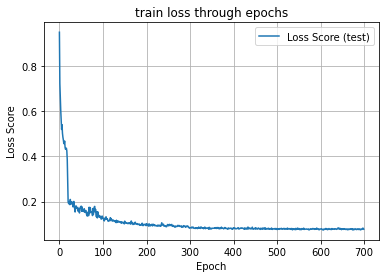

In [22]:
plt.plot(train_losses, label="Loss Score (test)")
plt.xlabel("Epoch")
plt.ylabel("Loss Score")
plt.title("train loss through epochs")
plt.grid(True)
plt.legend()
plt.show()

In [23]:
def plot_losses(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-', label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Test Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

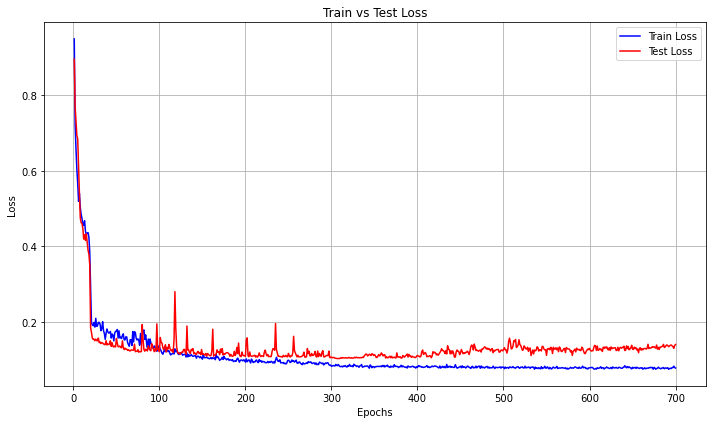

In [24]:
plot_losses(train_losses, val_losses)

## Verifica del modello(miglior) salvato sui dati di test

Total Avg Test Loss: 0.1037 | Avg L2 Loss: 0.0016 |Avg SSIM Loss: 0.0958| Avg Rec Loss: 0.0974 | Avg Seg Loss: 0.0063 
Average Precision: 0.7841 | AUROC: 0.9954


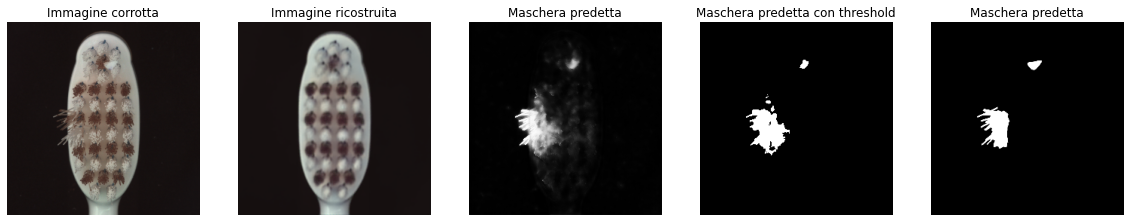

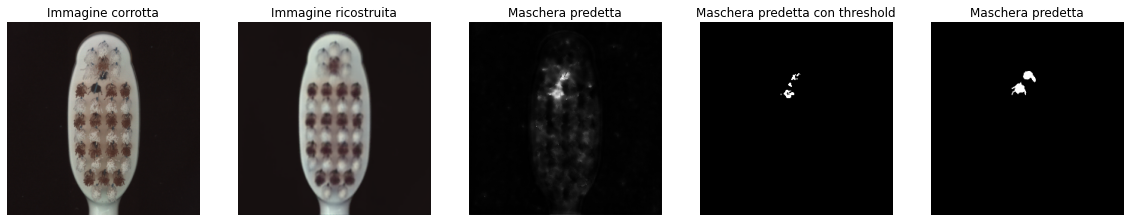

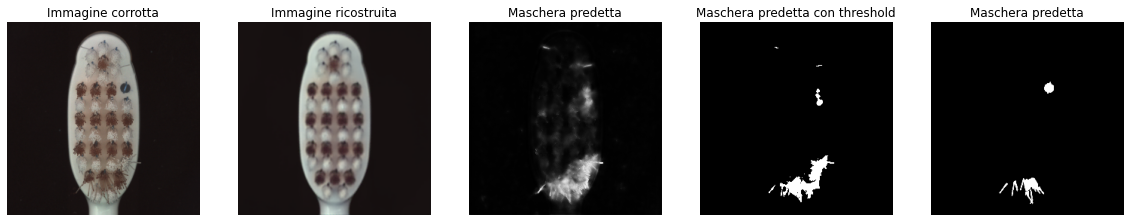

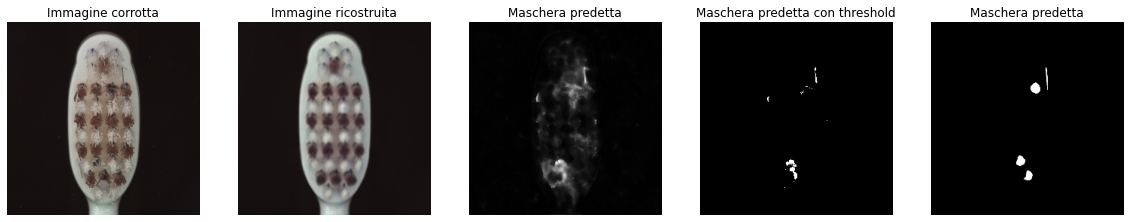

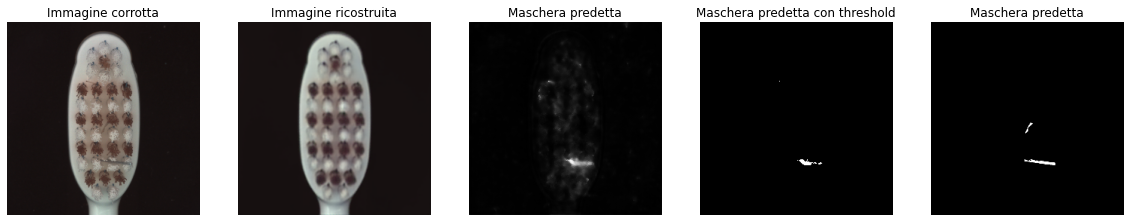

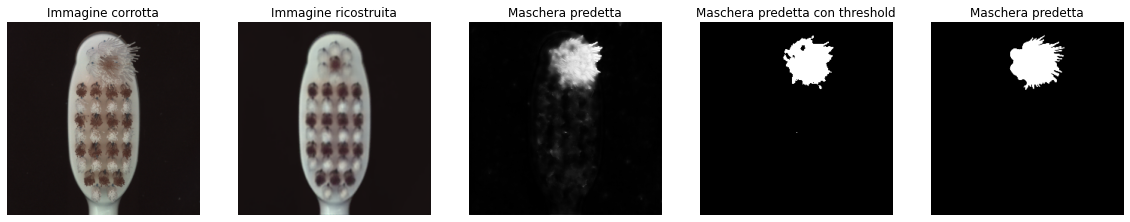

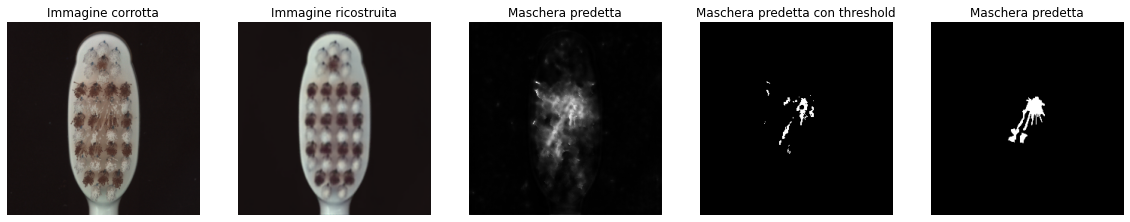

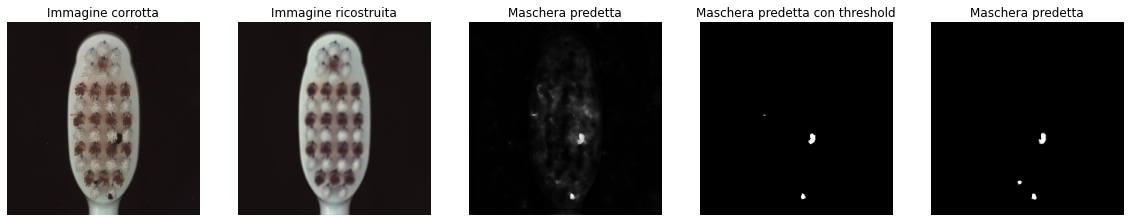

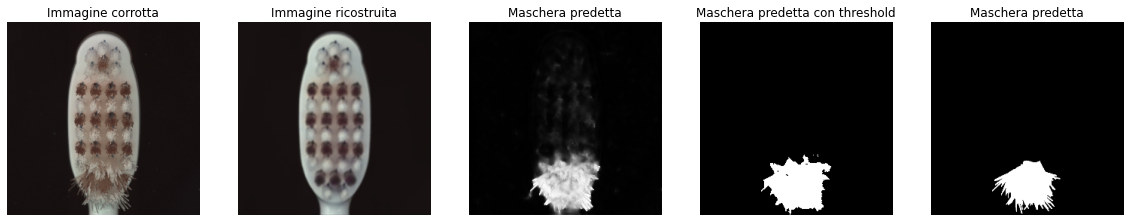

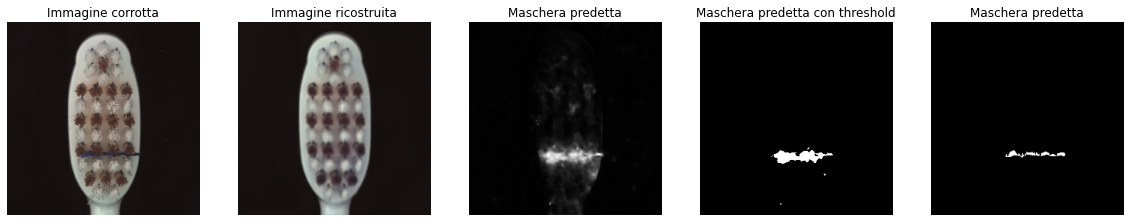

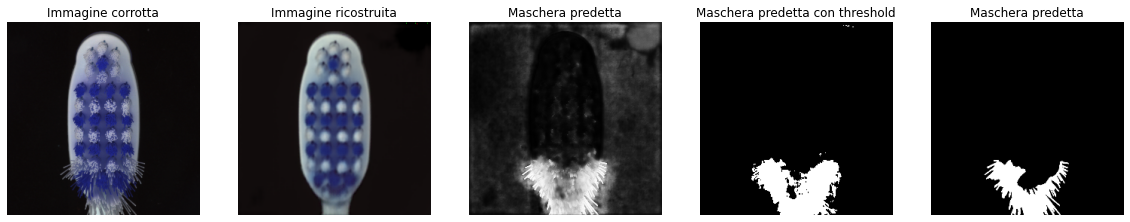

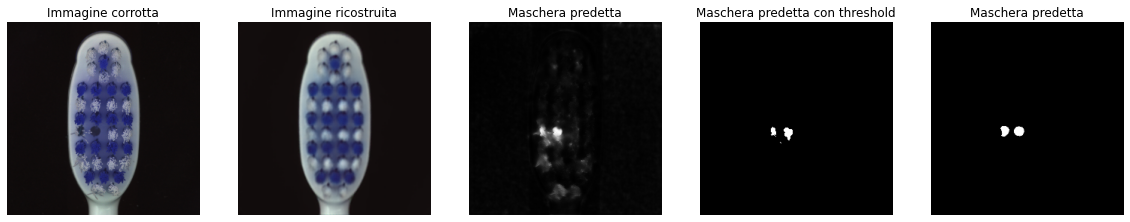

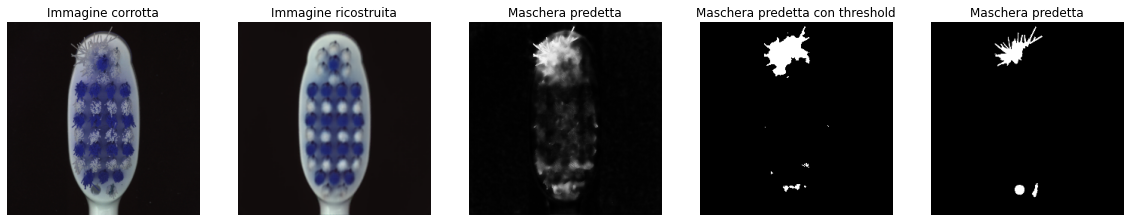

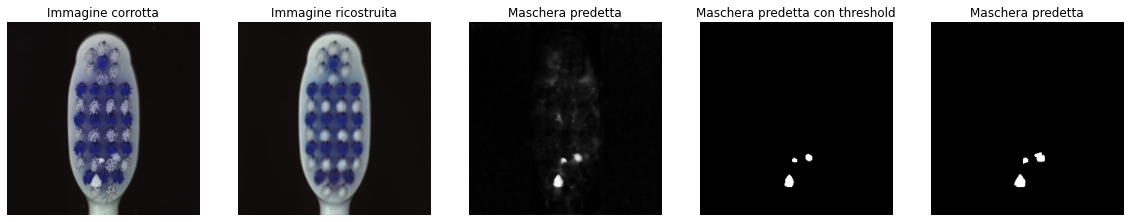

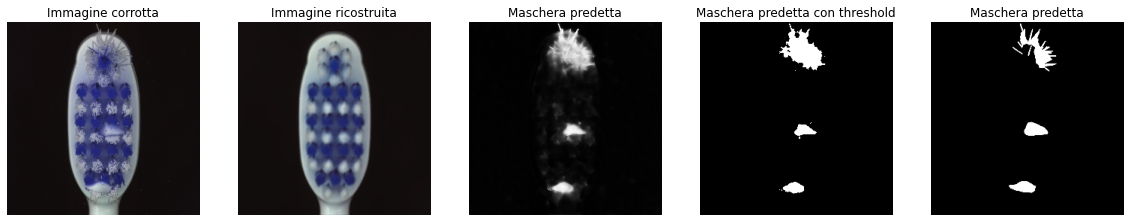

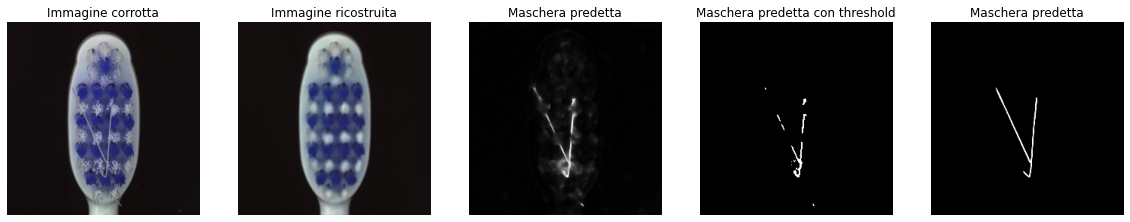

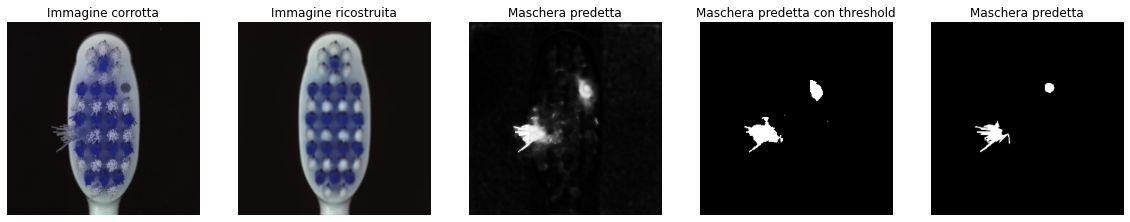

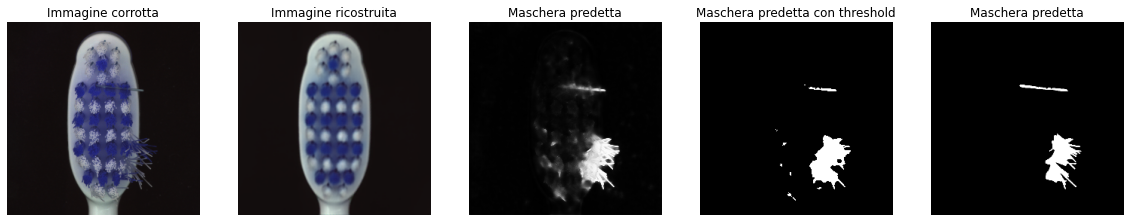

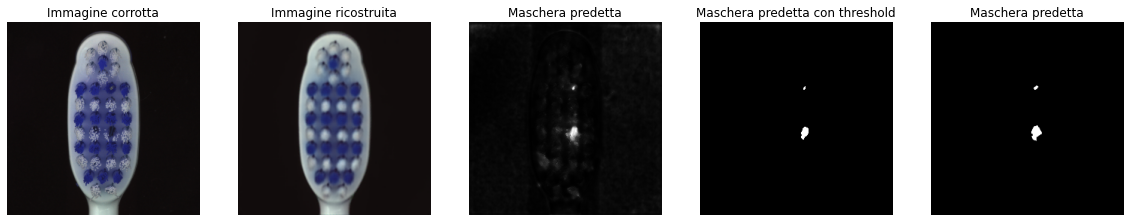

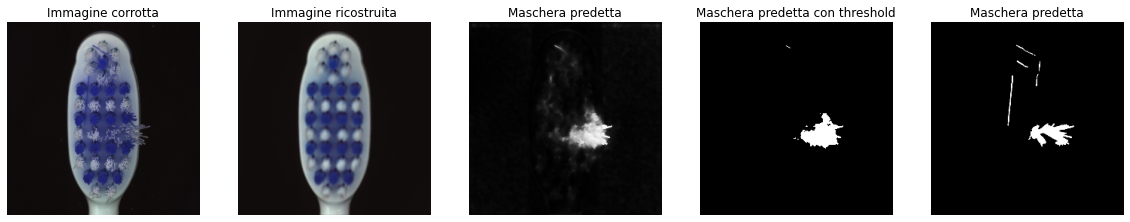

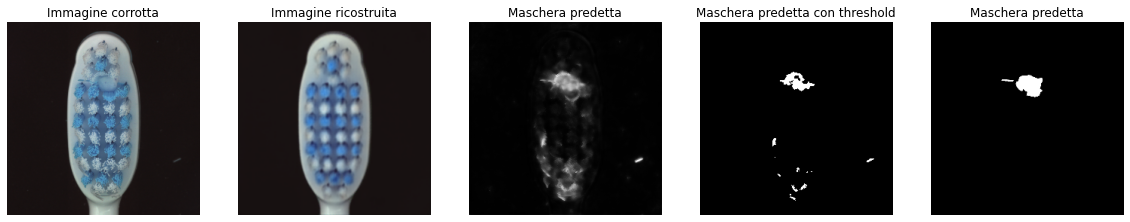

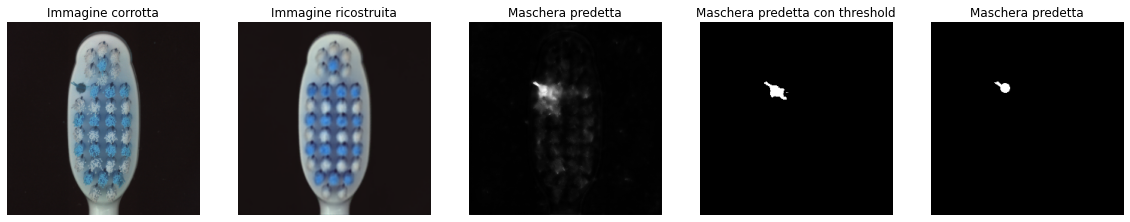

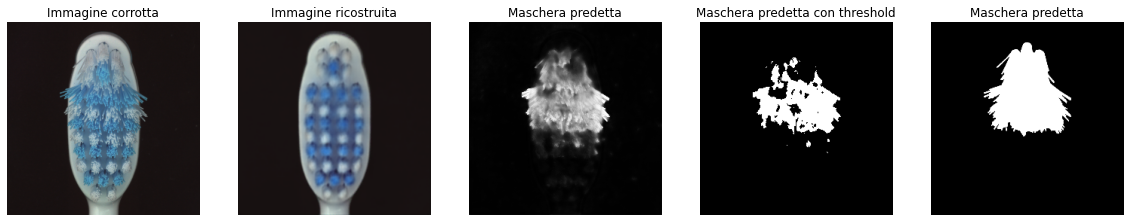

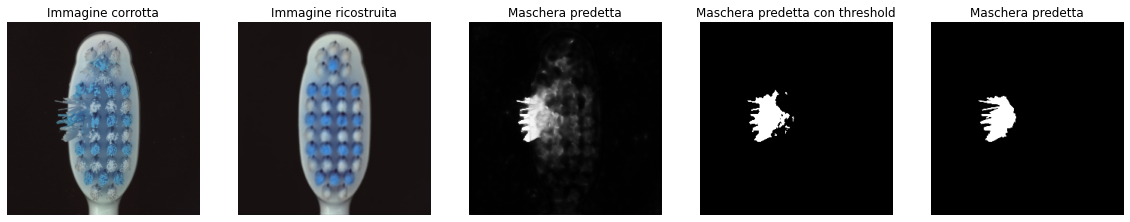

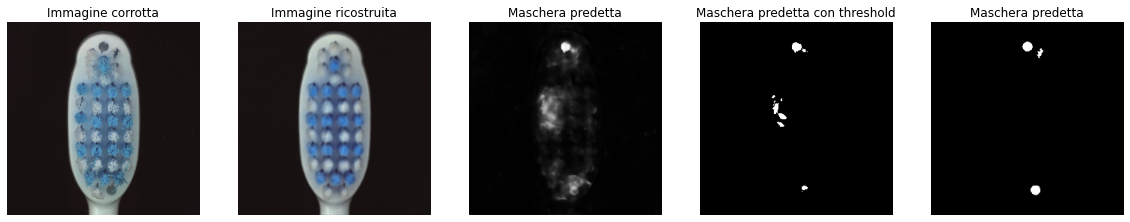

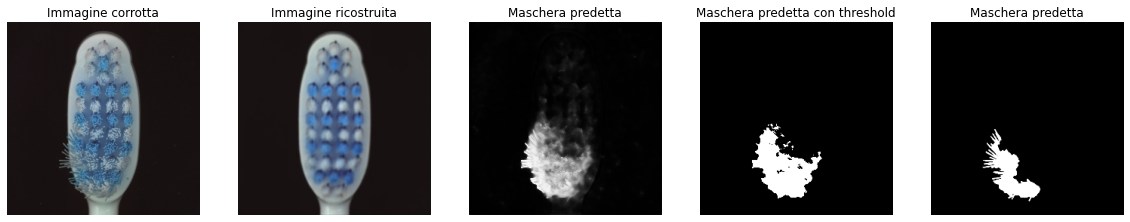

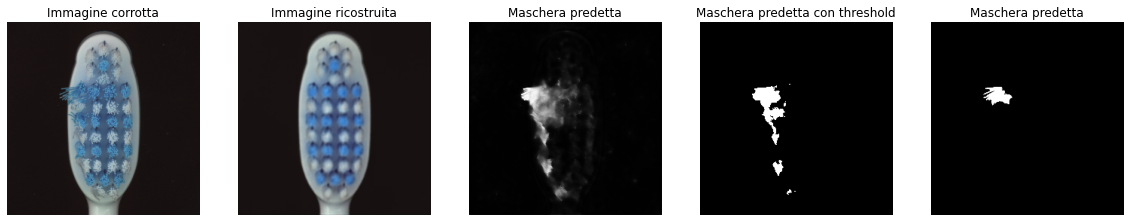

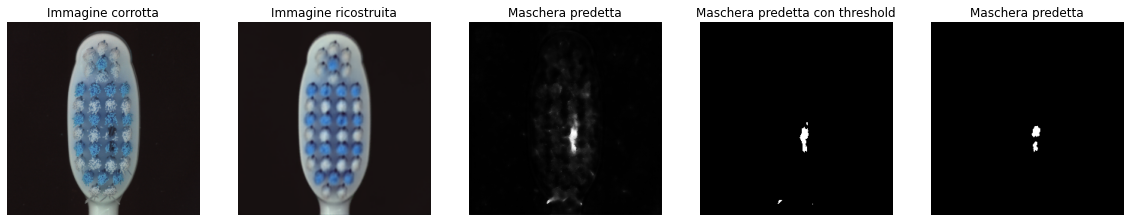

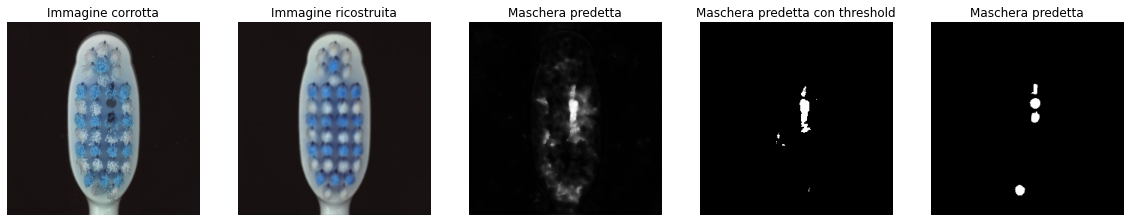

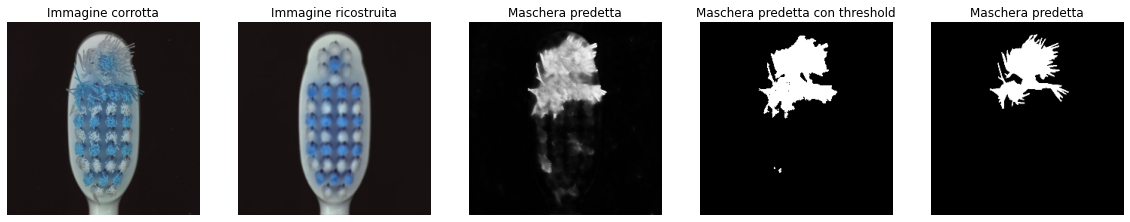

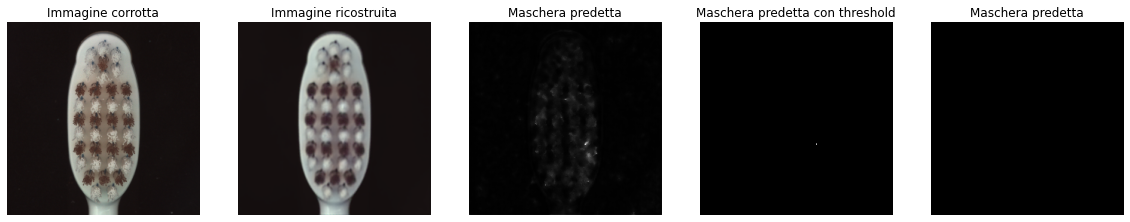

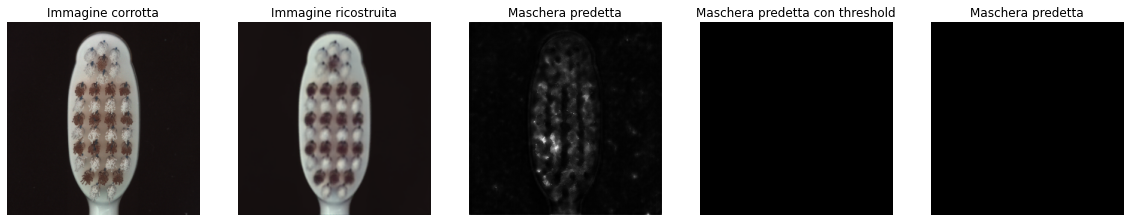

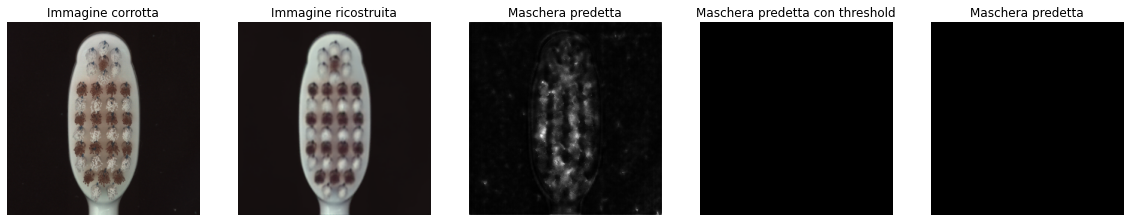

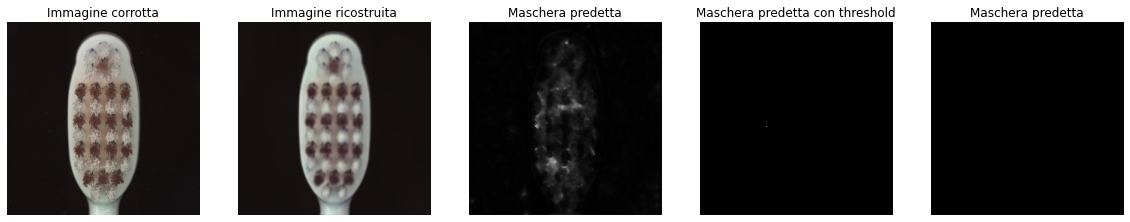

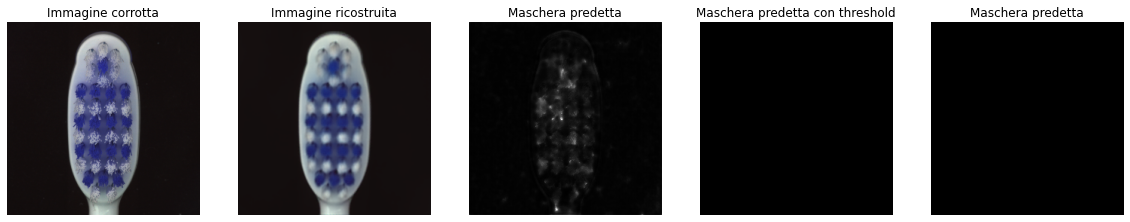

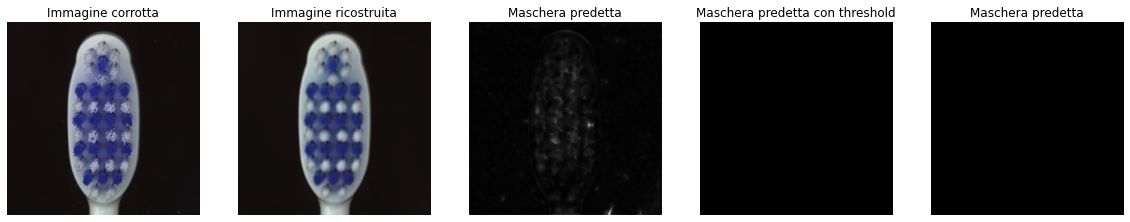

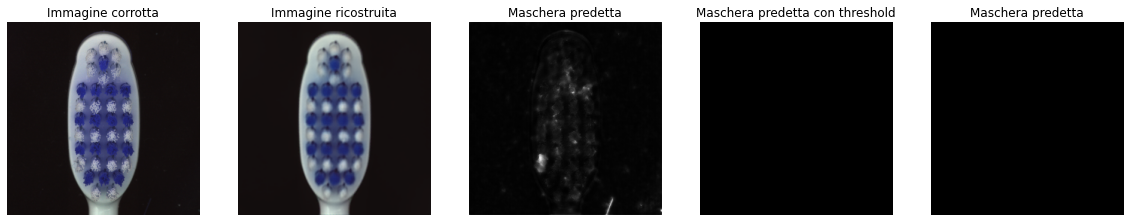

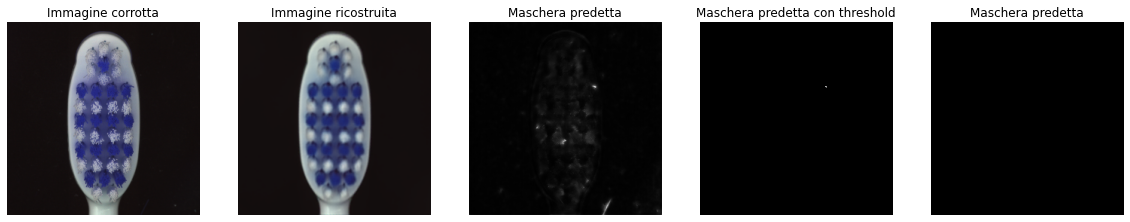

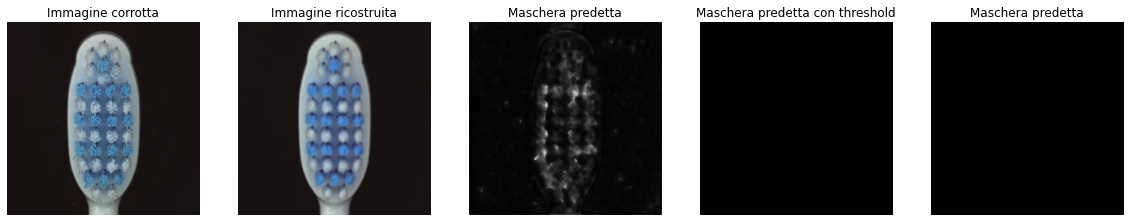

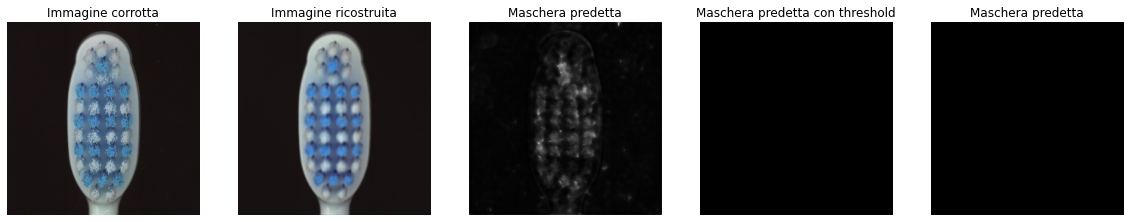

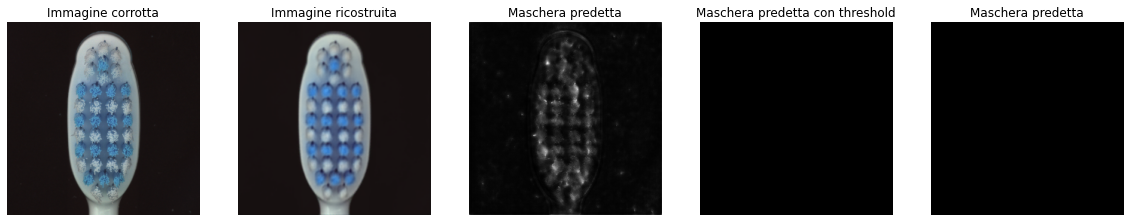

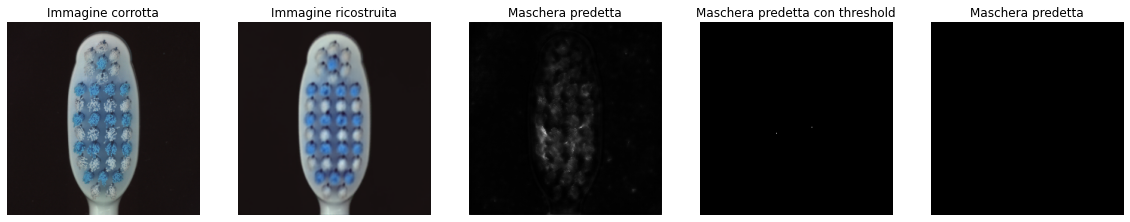

In [30]:
model_best = Draem()
model_best.load_state_dict(torch.load("draem_model.pckl"))
model_best.to(device)
model.eval()
test_step(model_best, dataloader_test, rec_loss, loss_l2, loss_focal,50)
with torch.no_grad():
    for batch in dataloader_val:
        inputs = batch["image"].cuda()
        gt_seg = batch["mask"].cuda().squeeze(1)
        rec, anomaly_logits = model_best(inputs)

        pred_seg = anomaly_logits[0,1,:,:].detach().cpu().numpy()

        threshold = 0.5
        anomaly_mask = (pred_seg > threshold)
        
        inp = inputs[0].cpu().permute(1,2,0).numpy()
        rec_img = rec[0].cpu().permute(1,2,0).numpy()
        pred_mask = pred_seg
        gt_mask = gt_seg[0].cpu().numpy()

        joined_input = torch.cat((rec, inputs), dim=1)
        
        fig, axs = plt.subplots(1,5, figsize=(20,5))
        axs[0].imshow(inp)
        axs[0].set_title("Immagine corrotta")
        axs[0].axis("off")
        axs[1].imshow((rec_img*255).astype(np.uint8), cmap="gray")
        axs[1].set_title("Immagine ricostruita")
        axs[1].axis("off")
        axs[2].imshow(pred_mask, cmap='gray')
        axs[2].set_title("Maschera predetta")
        axs[2].axis("off")
        axs[3].imshow(anomaly_mask, cmap='gray')
        axs[3].set_title("Maschera predetta con threshold")
        axs[3].axis("off")
        axs[4].imshow(gt_mask, cmap='gray')
        axs[4].set_title("Maschera predetta")
        axs[4].axis("off")
        plt.show()